# <center>Analyse du dataset initiale

## Chargement des données

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
sns.set()

df = pd.read_csv("data/events.csv")

## Analyse préliminaire

In [2]:
(100*df.isna().sum()/df.shape[0]).round(2)

timestamp         0.00
visitorid         0.00
event             0.00
itemid            0.00
transactionid    99.19
dtype: float64

Il y n'y a aucune valeur manquant sur les quatre premières colonnes. Par contre, la dernière contient pres de 99,2% de valeurs manquantes.

In [3]:
pd.crosstab(df['event'], df['transactionid'].isna(), rownames=["type d'event"], colnames=["NA transactionid "])

NA transactionid,False,True
type d'event,,
addtocart,0,69332
transaction,22457,0
view,0,2664312


On remarque que la totalité des events "transaction" ont un "transactionid" non nul. 
Aucun autre event ne comporte de transactionid

In [4]:
df.nunique() # Il y a presque autant de timestamp que de ligne, et il n'y a que trois event possible. 

timestamp        2750455
visitorid        1407580
event                  3
itemid            235061
transactionid      17672
dtype: int64

In [5]:
(100*df.nunique()/df.shape[0]).round(2) # le nombre de visitor Id unique représente la moitié du nombre de ligne, donc un visiteur effectue en moyenne 2 actions sur le site

timestamp        99.80
visitorid        51.07
event             0.00
itemid            8.53
transactionid     0.64
dtype: float64

In [6]:
df.duplicated().sum()

460

In [7]:
df.drop_duplicates(inplace=True)

## Visualisations

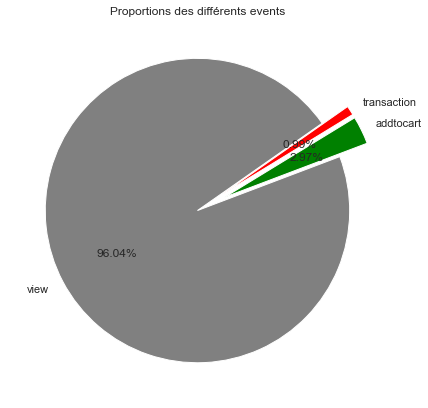

In [8]:
# Graphique piechart représentant la proportions des différentes occurences de la variable 'events'

explode = (0, 0.2, 0.2)  
colors = ['grey','green','red']
event_prop = (df.event.value_counts(normalize=True)).round(2)

plt.subplots(figsize=(8,7))

plt.pie(event_prop, 
        labels=event_prop.index,
        startangle=35,
        autopct='%.2f%%',
        explode=explode,
        colors=colors)

plt.title("Proportions des différents events");

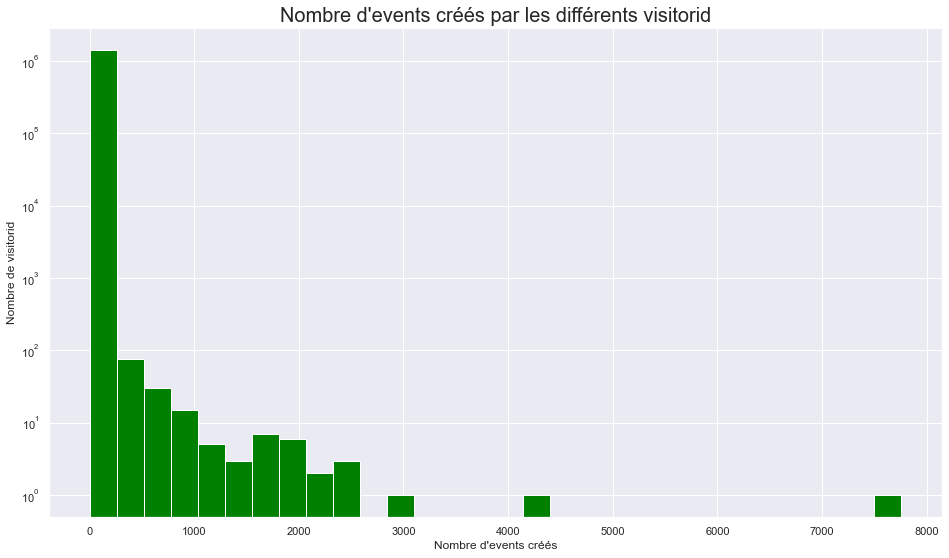

In [9]:
nb_visiteur = df.visitorid.value_counts()
param_hist = {'fontsize': 20}

plt.figure(figsize=(16, 9))
n, bins, patches = plt.hist(nb_visiteur.values, bins=30, log=True,color='green')

plt.xlabel("Nombre d'events créés")
plt.ylabel("Nombre de visitorid")
plt.title(label = "Nombre d'events créés par les différents visitorid",
         fontdict = param_hist );

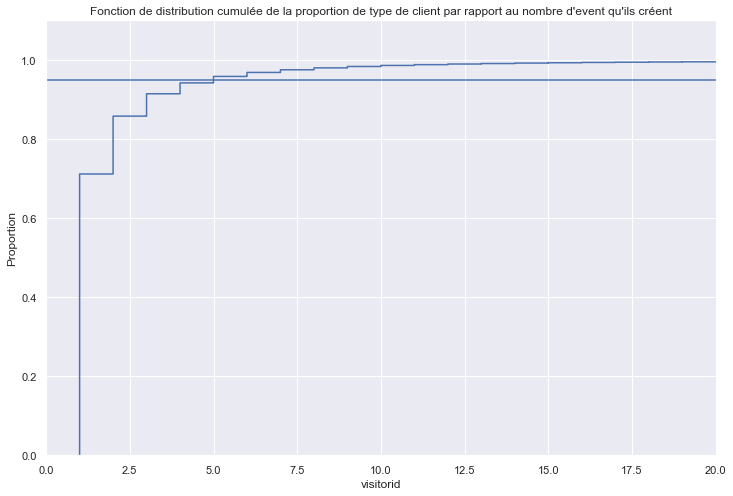

In [10]:
fig, ax = plt.subplots(figsize=(12,8))

sns.ecdfplot(nb_visiteur, ax=ax)
ax.axhline(y=0.95, )
ax.set_ylim([0,1.1])
ax.set_xlim([0,20])
ax.set_title("Fonction de distribution cumulée de la proportion de type de client par rapport au nombre d'event qu'ils créent");

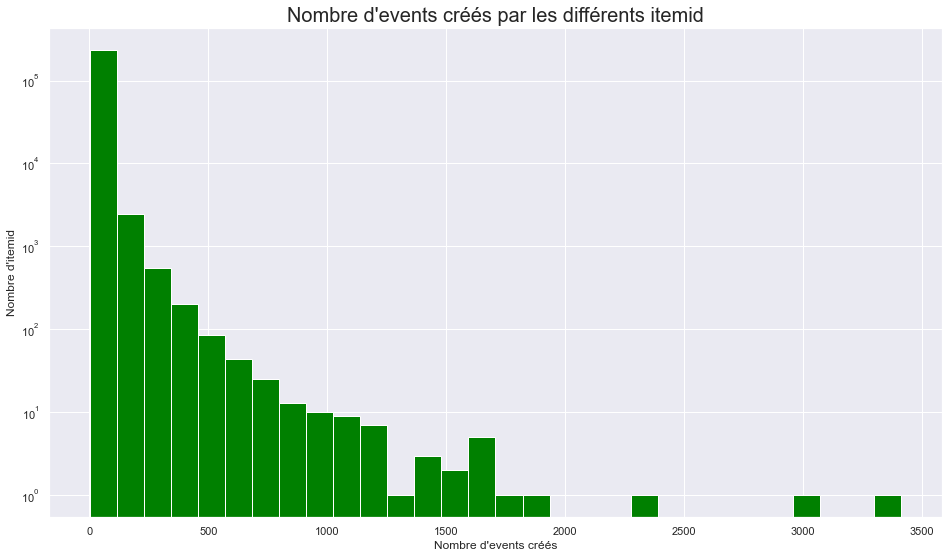

In [11]:
nb_product = df.itemid.value_counts()
plt.figure(figsize=(16, 9))
plt.hist(nb_product, bins=30, log=True,color='green')

plt.xlabel("Nombre d'events créés")
plt.ylabel("Nombre d'itemid")
plt.title(label = "Nombre d'events créés par les différents itemid",
         fontdict = param_hist );

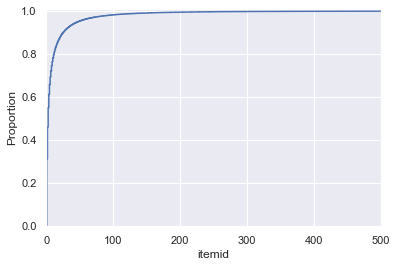

In [12]:
sns.ecdfplot(nb_product)
plt.ylim([0,1.01])
plt.xlim([0,500]);

C:\ProgramData\Anaconda3\envs\py_e_sales\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


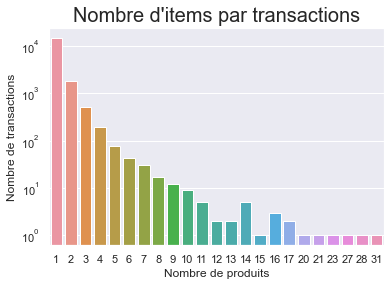

In [13]:
item_per_transaction = df[df['transactionid'].notnull()].groupby(['transactionid']).count()['timestamp']
sns.countplot(item_per_transaction, log = True)

plt.xlabel("Nombre de produits")
plt.ylabel("Nombre de transactions")
plt.title("Nombre d'items par transactions",
         fontdict = param_hist);

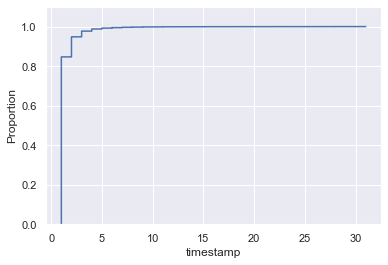

In [14]:
sns.ecdfplot(item_per_transaction)
plt.ylim([0,1.1]);

In [15]:
df = df.merge(pd.get_dummies(df['event']), left_index=True, right_index=True)

df['date'] = pd.to_datetime(df['timestamp'], unit='ms')
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['hour'] = df['date'].dt.hour
df['weekday'] = df["date"].dt.weekday
df['month-day'] = df['date'].dt.strftime("%m-%d")

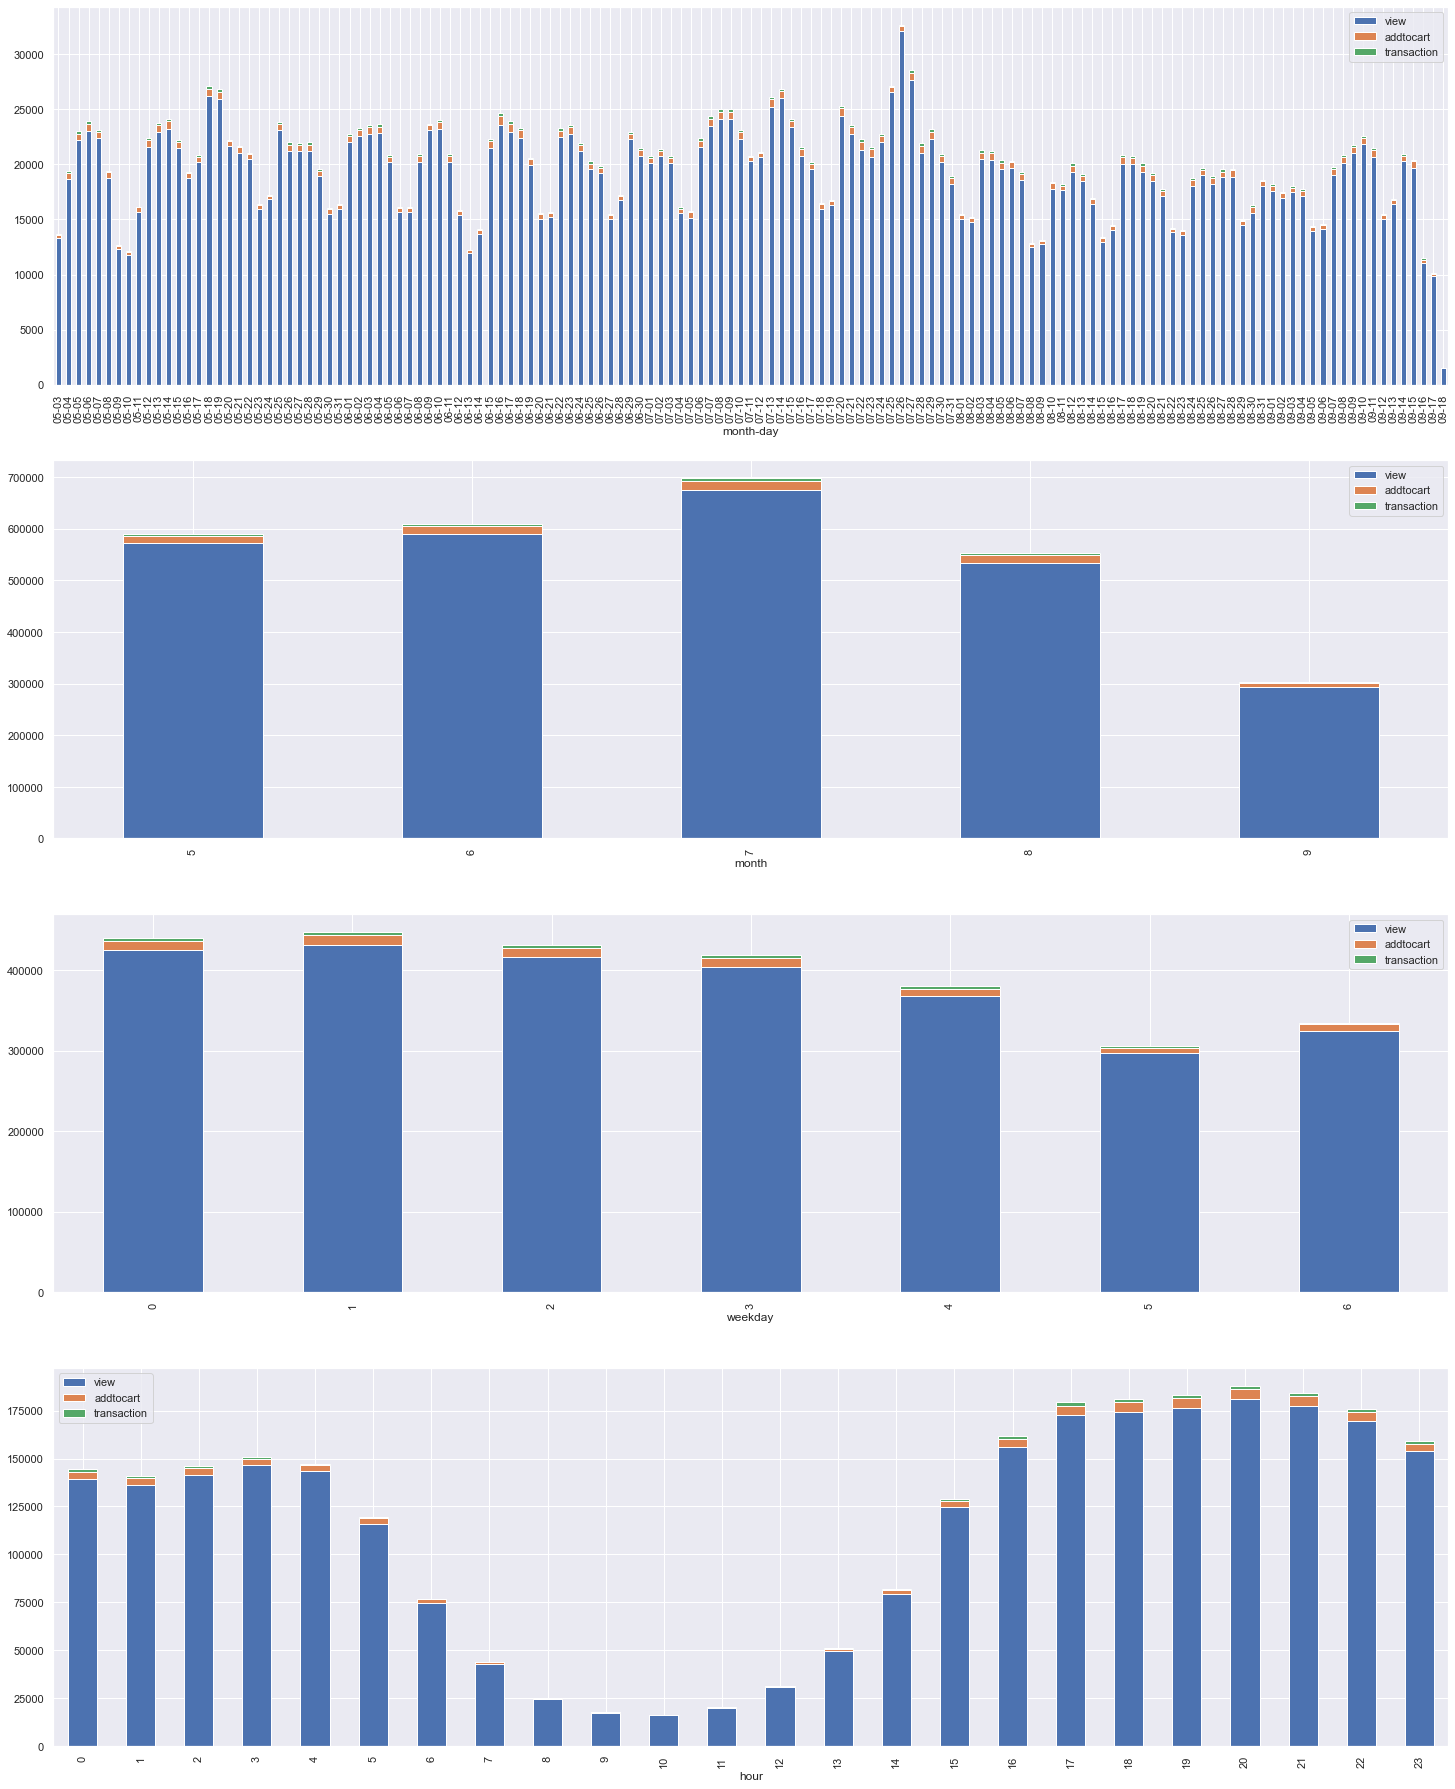

In [16]:
cols = ['month-day', 'month', 'weekday','hour']
fig, axes = plt.subplots(len(cols),1, figsize=(25,32))
for col , ax in zip(cols, axes.flat):
    event_agg = df[[col,'view','addtocart','transaction']].groupby(col).sum()
    event_agg.plot(kind='bar', stacked=True, ax=ax)

On remarque une légère variation entre les mois, mais il n'est pas possible d'extraire de saisonalité car le dataset ne couvre pas plusieurs années.

En ce qui concerne les jours de la semaine, on voit une diminution relative du nombre d'évènement pour les jours de Weekend. 

Enfin, on remarque un effet franc de l'heure dans le nombre d'évènement et on remarque également que les heures 8, 9,10,11, 12 ne comporte aucun ajout au panier, ni achat. 

In [17]:
df.sort_values(['visitorid','timestamp'], inplace=True)

df['diftime(m)'] = (df['timestamp'].diff()/60000)*df['visitorid'].duplicated()
df['diftime(m)']=df['diftime(m)'].shift(-1)


Décalage de la colonne diftime pour que la durée corresponde à l'event: Pour chaque rang, la valeur diftime est calculé en faisant la différence du rang d'avec le rang précédent. Alors que Pour calculer la durée passé par event, le timestamp correspond au début et le timestamp de l'évènement suivant est la fin de l'évènement en question. Cela veut dire que nous ne pouvons pas non plus calculer le temps passé sur le dernier event.

In [18]:
df['diftime(m)'] = df['diftime(m)'].replace(0, np.nan)

Le changement des 0 en Nan permettra lors de calcul de moyenne ou somme de ne pas tenir compte de ces valeurs

In [19]:
def chi2_test(df, col1, col2):
    cross_tab = pd.crosstab(df[col1], df[col2])
    chi2, p_val, dof, exp = stats.chi2_contingency(cross_tab)
    print(f"La p-value du test est de {p_val:.2f}, l'hypothèse d'indépendance entre {col1} et {col2} est donc {'rejetée' if p_val < 0.05 else 'acceptée'}")

In [20]:
chi2_test(df, 'event', 'month')
chi2_test(df, 'event', 'hour')
chi2_test(df, 'event', 'weekday')

La p-value du test est de 0.00, l'hypothèse d'indépendance entre event et month est donc rejetée
La p-value du test est de 0.00, l'hypothèse d'indépendance entre event et hour est donc rejetée
La p-value du test est de 0.00, l'hypothèse d'indépendance entre event et weekday est donc rejetée


In [21]:
df['weekend'] = df['weekday'].isin([5,6])
# Il semble y avoir une baisse de l'activité les Samedi et Dimanche
# On crée la variable weekend qui condensera l'information

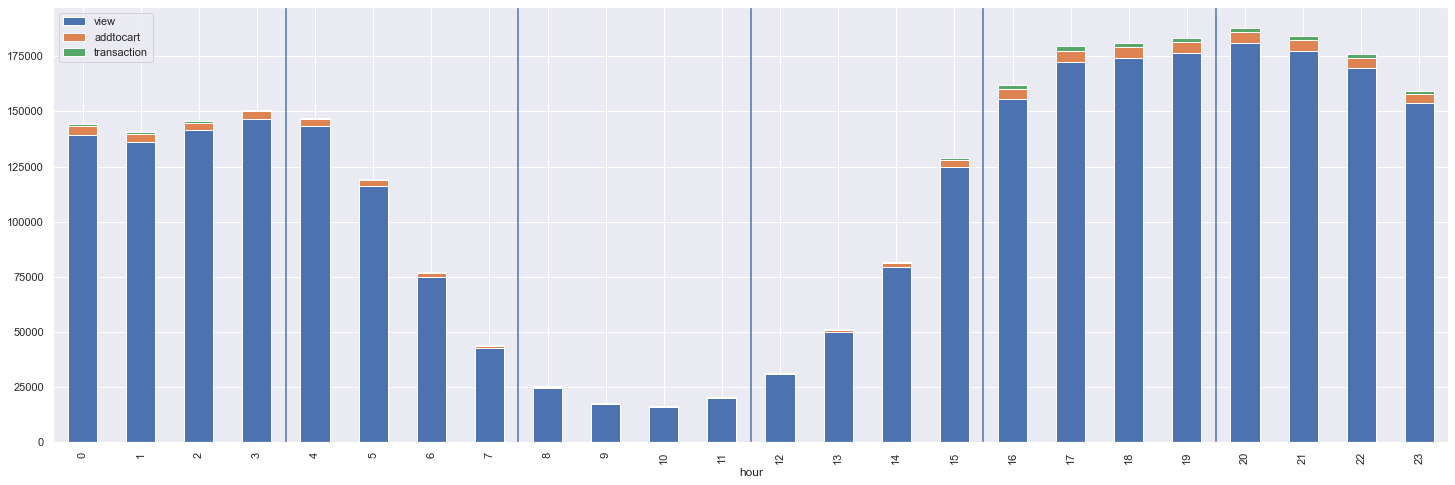

In [22]:
fig, ax = plt.subplots(figsize=(25,8))
event_agg = df[['hour','view','addtocart','transaction']].groupby('hour').sum()
event_agg.plot(kind='bar', stacked=True, ax=ax)
ax.axvline(x=3.5)
ax.axvline(x=7.5)
ax.axvline(x=11.5)
ax.axvline(x=15.5)
ax.axvline(x=19.5);

In [23]:
hour_class = {1:[0,1,2,3],
              2:[4,5,6,7],
              3:[8,9,10,11],
              4:[12,13,14,15],
              5:[16,17,18,19],
              6:[20,21,22,23]}

hour_replace = {}
for key,values in hour_class.items():
  for value in values:
    hour_replace[value]=key

df['hourclass'] = df['hour'].replace(hour_replace)
df = df.merge(pd.get_dummies(df['hourclass'], prefix='hourclass'), left_index=True, right_index=True)


In [24]:
df.head()

,timestamp,visitorid,event,itemid,transactionid,addtocart,transaction,view,date,month,...,month-day,diftime(m),weekend,hourclass,hourclass_1,hourclass_2,hourclass_3,hourclass_4,hourclass_5,hourclass_6
1361687,1442004589439,0,view,285930,NaN,0,0,1,2015-09-11 20:49:49.439,9,...,09-11,2.835867,False,6,0,0,0,0,0,1
1367212,1442004759591,0,view,357564,NaN,0,0,1,2015-09-11 20:52:39.591,9,...,09-11,2.626400,False,6,0,0,0,0,0,1
1367342,1442004917175,0,view,67045,NaN,0,0,1,2015-09-11 20:55:17.175,9,...,09-11,NaN,False,6,0,0,0,0,0,1
830385,1439487966444,1,view,72028,NaN,0,0,1,2015-08-13 17:46:06.444,8,...,08-13,NaN,False,5,0,0,0,0,1,0
742616,1438969904567,2,view,325215,NaN,0,0,1,2015-08-07 17:51:44.567,8,...,08-07,1.820383,False,5,0,0,0,0,1,0


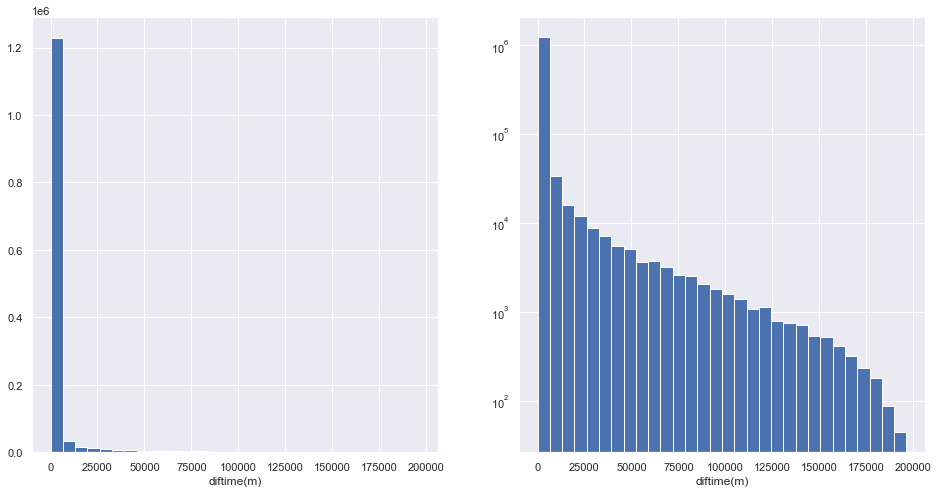

In [25]:
fig, axes = plt.subplots(1,2, figsize=(16,8))
axes[0].hist(df[~df['diftime(m)'].isna()]['diftime(m)'], bins=30)
axes[0].set_xlabel('diftime(m)')
axes[1].hist(df['diftime(m)'], bins=30)
axes[1].set_xlabel('diftime(m)')
axes[1].set_yscale('log');

La première chose que l'on note sur la distribution des temps des events est que les valeur extrême sont abérantes: 200000 minutes correspondent à 4 mois et demi soit le temps complet couvert par le dataset.

Une personne normale reste quelques heures sur un site mais si elle oublie de fermer sa fenetre, le temps entre deux clic peux continue de grimper jusqu'au lendemain soit 24h

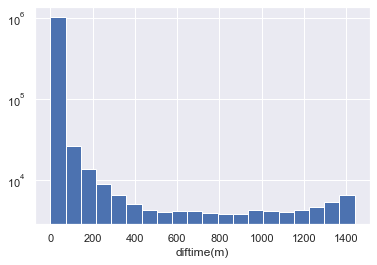

In [26]:
plt.hist(df[df['diftime(m)']<(60*24)]['diftime(m)'], bins=20)
plt.xlabel('diftime(m)')
plt.yscale('log');

Lorsque l'on regarde cette distribution, on voit que autour de 800 minutes (ce qui correspond à 13h) il y a un point bas dans la répartition des temps entre deux clics. Ceci peut être le signe d'un changement de comportement: avant 800 minutes, il s'agit d'un corportement normal qui peut trainer et au dela, cela représenterais le comportement d'une autre population qui tend à laisser tout le temps sa session ouverte (comme pour des robots par exemple).

On peut considérer que quelques soit l'individu derrière l'ordinateur, lorsqu'il s'est écoulé plus de 13h après le dernier clic, c'est comme s'il s'agissait d'une nouvelle session de navigation. 

In [27]:
nb_diftime_sup_800 = (df["diftime(m)"]>800).sum()
nb_diftime_inf_800 = (df["diftime(m)"]<=800).sum()
print(f'nombre de diftime supérieur à 800: {nb_diftime_sup_800}')

print(f'nombre de diftime inférieur à 800: {nb_diftime_inf_800}')

print(f"Soit {100*nb_diftime_sup_800/(nb_diftime_sup_800+nb_diftime_inf_800):.2f} % des events ont un temp d'execution supérieurs à 800 minutes")



nombre de diftime supérieur à 800: 229392
nombre de diftime inférieur à 800: 1116043
Soit 17.05 % des events ont un temp d'execution supérieurs à 800 minutes


In [28]:
df['changementsession'] = df['diftime(m)']>(800)
#comme on considère que les changement de session apparaisse lorsque diftime(m) >800, 
#alors diftime doit être remis à zeros comme s'il s'agissait d'un nouveau visiteur
df['diftime(m)'] = df['diftime(m)']*(~df['changementsession'])



In [29]:
x = df[df['diftime(m)']==0]['visitorid'].nunique()

y = df['visitorid'].nunique()

print(f"le nombre de visiteur qui passé plus de 13h est:{x}, soit {100*x/y:.2f}% des visiteurs")

le nombre de visiteur qui passé plus de 13h est:137599, soit 9.78% des visiteurs


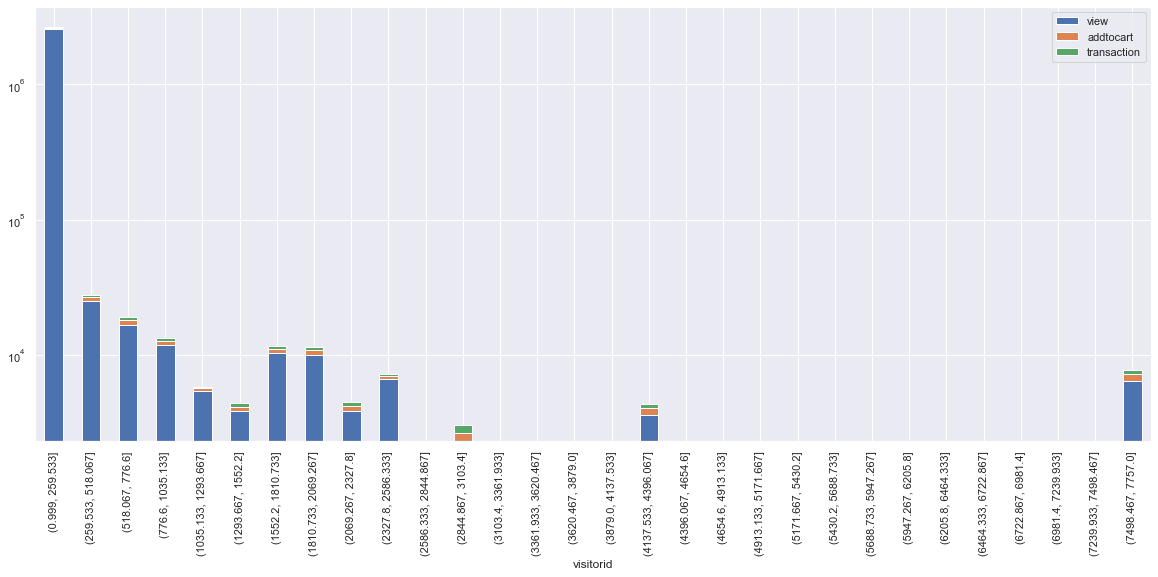

In [30]:
plot = df[['visitorid','view','addtocart','transaction']].groupby('visitorid').sum().merge(pd.cut(nb_visiteur, bins=bins, include_lowest=True), left_index=True, right_index=True).groupby('visitorid').sum()
fig, ax = plt.subplots(figsize=(20,8))
plot.plot(kind='bar', stacked=True, ax=ax)
plt.yscale('log');

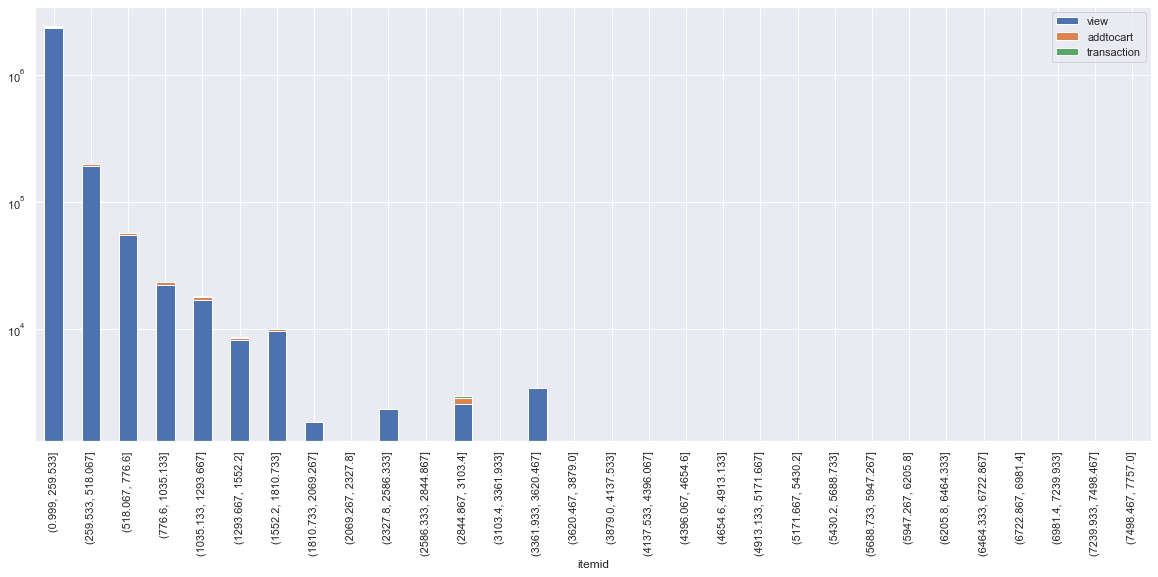

In [31]:
plot = df[['itemid','view','addtocart','transaction']].groupby('itemid').sum().merge(pd.cut(nb_product, bins=bins, include_lowest=True), left_index=True, right_index=True).groupby('itemid').sum()
fig, ax = plt.subplots(figsize=(20,8))
plot.plot(kind='bar', stacked=True, ax=ax)
plt.yscale('log');

Les dernières variables que l'on peut manipuler sont les temps dédier à chaque event. l'idée est de pouvoir calculer une moyenne de temps passé par évènement lors de l'agglomération selon la maille choisie.

In [32]:
df['time_for_view'] = (df['view']*df['diftime(m)']).replace(0, np.nan)
df['time_for_addtocart'] = (df['addtocart']*df['diftime(m)']).replace(0, np.nan)
df['time_for_transaction'] = (df['transaction']*df['diftime(m)']).replace(0, np.nan)

# on choisi de mettre des nan et non des zeros pour lors du calcul de moyenne ou de somme que les nan soit ignoré

In [33]:
df.to_csv('data/featured_events.csv')